##### Imports

In [1]:
import os.path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-12-22 10:38:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-22 10:38:18 (71.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (250, 250)
RANDOM_SEED = 42

DATA_PATH = '/content/drive/MyDrive/50-50'  # Local or Drive path to the images
IMG_DIR = Path(DATA_PATH)

##### Data helper functions

In [5]:
def split_df(df: pd.DataFrame, cols: list, **kwargs) -> pd.DataFrame:
    df1 = pd.DataFrame()

    for k, v in kwargs.items():
        df2 = df.loc[df['Label'] == k][cols].sample(n=v)
        df1 = pd.concat([df1, df2])

    df1.index = range(len(df1))
    return df1

In [6]:
def train_model(pretrained_model: MobileNetV2, train_images, val_images) -> tuple:
    inputs = pretrained_model.input
    X = resize_and_rescale(inputs)

    X = Dense(256, activation='relu')(pretrained_model.output)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.2)(X)


    outputs = Dense(2, activation='softmax')(X)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback(
                'training_logs', 
                'fire_classification'
            ),
            checkpoint_callback,
        ]
    )

    return model, history

##### Plot functions

In [7]:
def plot_random_images(df: pd.DataFrame) -> None:
    random_index = np.random.randint(0, len(df), 16)
    fig, axes = plt.subplots(
        nrows=4,
        ncols=4,
        figsize=(10, 10),
        subplot_kw={'xticks': [], 'yticks': []}
    )

    for i, ax in enumerate(axes.flat):
        image = Image.open(df.Filepath[random_index[i]])
        ax.imshow(image)
        ax.set_title(df.Label[random_index[i]])

    plt.tight_layout()
    plt.show()

def plot_predictions(df: pd.DataFrame, preds: list) -> None:
    random_index = np.random.randint(0, len(df) - 1, 15)
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image = Image.open(df.Filepath.iloc[random_index[i]])
        ax.imshow(image)
        if df.Label.iloc[random_index[i]] == preds[random_index[i]]:
          color = 'green'
        else:
          color = 'red'
        ax.set_title(
            f'True: {df.Label.iloc[random_index[i]]}\nPredicted: {preds[random_index[i]]}',
            color=color
        )
    plt.show()
    plt.tight_layout()

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

    if savefig:
        fig.savefig("confusion_matrix.png")

In [8]:
walk_through_dir(DATA_PATH)

There are 2 directories and 0 images in '/content/drive/MyDrive/50-50'.
There are 0 directories and 1450 images in '/content/drive/MyDrive/50-50/fire'.
There are 0 directories and 1458 images in '/content/drive/MyDrive/50-50/nonfire'.


In [9]:
filepaths = list(IMG_DIR.glob(r'**/*.JPG')) + list(IMG_DIR.glob(r'**/*.jpg')) + list(IMG_DIR.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/content/drive/MyDrive/50-50/fire/fire_0270.jpg,fire
1,/content/drive/MyDrive/50-50/fire/fire_0247.jpg,fire
2,/content/drive/MyDrive/50-50/fire/fire_0252.jpg,fire
3,/content/drive/MyDrive/50-50/fire/fire_0256.jpg,fire
4,/content/drive/MyDrive/50-50/fire/fire_0263.jpg,fire
...,...,...
2903,/content/drive/MyDrive/50-50/nonfire/nofire_02...,nonfire
2904,/content/drive/MyDrive/50-50/nonfire/nofire_02...,nonfire
2905,/content/drive/MyDrive/50-50/nonfire/nofire_02...,nonfire
2906,/content/drive/MyDrive/50-50/nonfire/nofire_02...,nonfire


Split data into smaller datasets.
*   50-50% fire-nonfire
*   70-30% fire-nonfire
*   30-70% fire-nonfire



In [10]:
df_50_50 = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=250,
    nonfire=250
)
df_70_30 = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=350,
    nonfire=150
)
df_30_70 = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=150,
    nonfire=350
)

In [11]:
df_50_50

,Filepath,Label
0,/content/drive/MyDrive/50-50/fire/fire_0053.jpg,fire
1,/content/drive/MyDrive/50-50/fire/fire-339.jpg,fire
2,/content/drive/MyDrive/50-50/fire/fire_0357.jpg,fire
3,/content/drive/MyDrive/50-50/fire/fire-256.jpg,fire
4,/content/drive/MyDrive/50-50/fire/fire_0719.jpg,fire
...,...,...
495,/content/drive/MyDrive/50-50/nonfire/nofire_04...,nonfire
496,/content/drive/MyDrive/50-50/nonfire/nofire_00...,nonfire
497,/content/drive/MyDrive/50-50/nonfire/nofire_04...,nonfire
498,/content/drive/MyDrive/50-50/nonfire/forest-21...,nonfire


In [12]:
df_70_30.loc[df_70_30['Label'] == 'nonfire']

,Filepath,Label
350,/content/drive/MyDrive/50-50/nonfire/nofire_01...,nonfire
351,/content/drive/MyDrive/50-50/nonfire/nofire_02...,nonfire
352,/content/drive/MyDrive/50-50/nonfire/abc255.jpg,nonfire
353,/content/drive/MyDrive/50-50/nonfire/nofire_07...,nonfire
354,/content/drive/MyDrive/50-50/nonfire/nofire_02...,nonfire
...,...,...
495,/content/drive/MyDrive/50-50/nonfire/forest-10...,nonfire
496,/content/drive/MyDrive/50-50/nonfire/forest-43...,nonfire
497,/content/drive/MyDrive/50-50/nonfire/nofire_01...,nonfire
498,/content/drive/MyDrive/50-50/nonfire/forest-49...,nonfire


##### Train 50-50

In [13]:
train_df, test_df = train_test_split(
    df_50_50, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=(250, 250, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
test_images

In [ ]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [ ]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20221221-160106
Epoch 1/100
10/10 [==============================] - 24s 2s/step - loss: 0.6836 - accuracy: 0.6219 - val_loss: 0.4431 - val_accuracy: 0.8125
Epoch 2/100
10/10 [==============================] - 24s 3s/step - loss: 0.3654 - accuracy: 0.8656 - val_loss: 0.2083 - val_accuracy: 0.9625
Epoch 3/100
10/10 [==============================] - 21s 2s/step - loss: 0.2064 - accuracy: 0.9594 - val_loss: 0.1370 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 20s 2s/step - loss: 0.1395 - accuracy: 0.9750 - val_loss: 0.1049 - val_accuracy: 0.9875
Epoch 5/100
10/10 [==============================] - 20s 2s/step - loss: 0.1131 - accuracy: 0.9688 - val_loss: 0.0886 - val_accuracy: 0.9875
Epoch 6/100
10/10 [==============================] - 26s 3s/step - loss: 0.0789 - accuracy: 0.9812 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 22s 2s/step - loss

In [ ]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.01777
Test Accuracy:  99.00


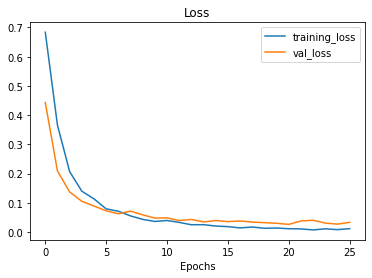

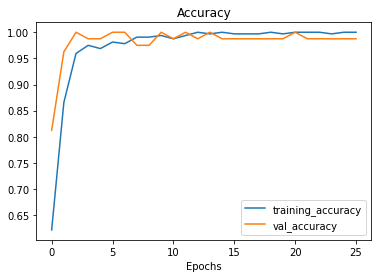

In [ ]:
plot_loss_curves(history)

In [ ]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

4/4 [==============================] - 5s 907ms/step
The first 5 predictions: ['nonfire', 'fire', 'nonfire', 'fire', 'fire']


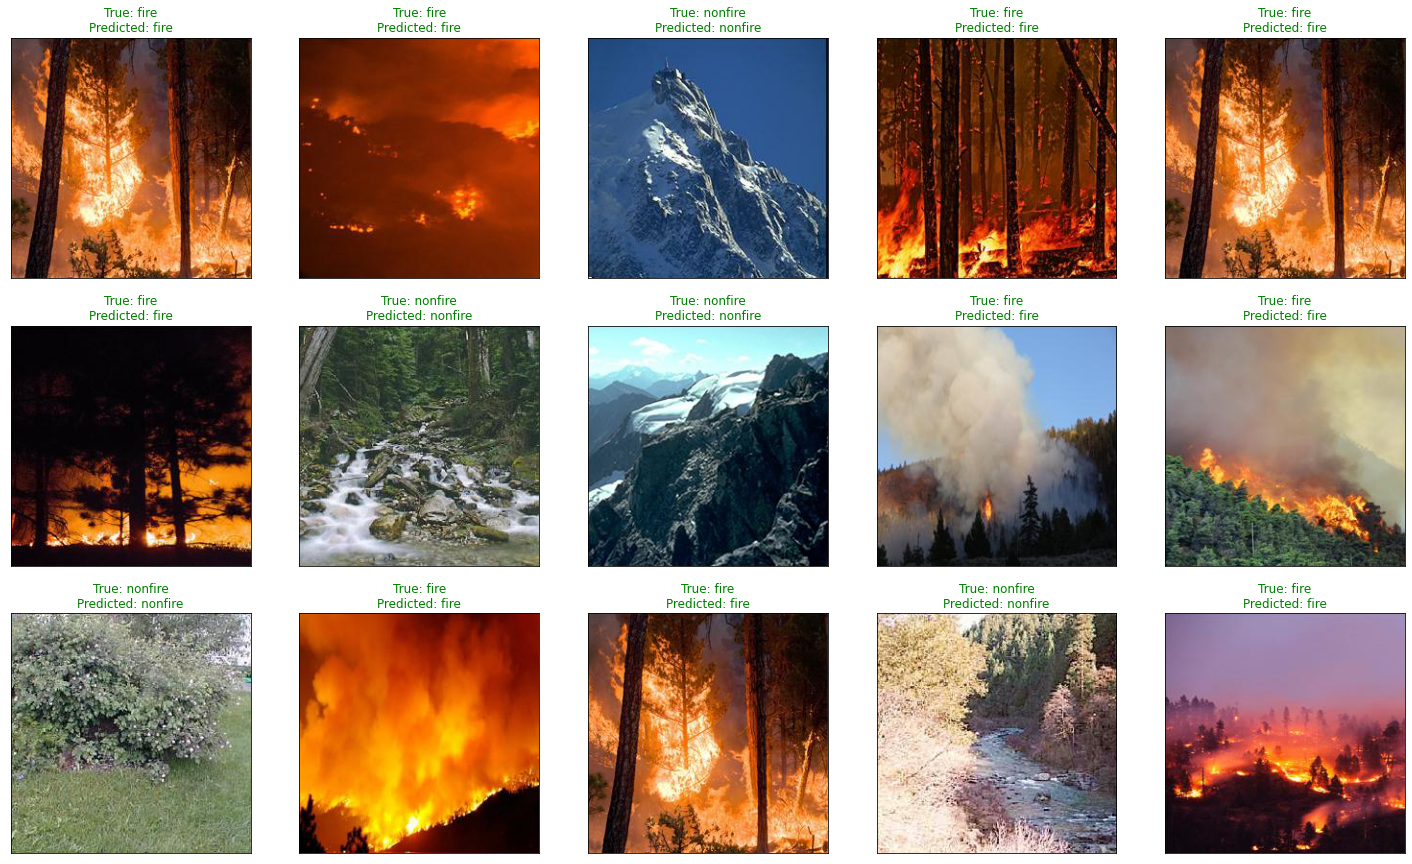

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_predictions(test_df, predictions)

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       1.00      0.98      0.99        46
     nonfire       0.98      1.00      0.99        54

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

,precision,recall,f1-score,support
fire,1.000000,0.978261,0.989011,46.00
nonfire,0.981818,1.000000,0.990826,54.00
accuracy,0.990000,0.990000,0.990000,0.99
macro avg,0.990909,0.989130,0.989918,100.00
weighted avg,0.990182,0.990000,0.989991,100.00


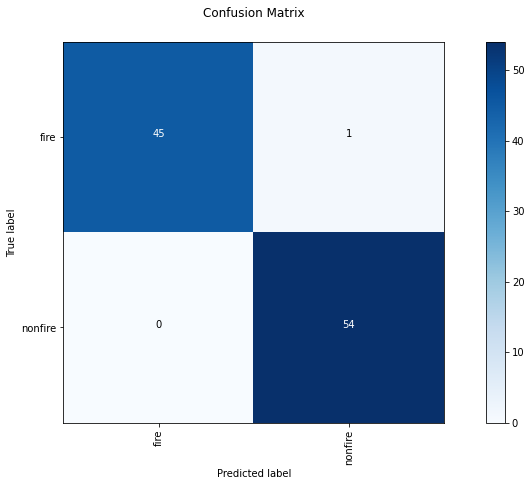

In [ ]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [ ]:
model.save('model_50-50.h5')

##### Train 70-30

In [ ]:
train_df, test_df = train_test_split(
    df_70_30, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [ ]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20221221-161617
Epoch 1/100
10/10 [==============================] - 218s 16s/step - loss: 0.6700 - accuracy: 0.6000 - val_loss: 0.4024 - val_accuracy: 0.7875
Epoch 2/100
10/10 [==============================] - 19s 2s/step - loss: 0.3810 - accuracy: 0.8125 - val_loss: 0.3148 - val_accuracy: 0.8375
Epoch 3/100
10/10 [==============================] - 17s 2s/step - loss: 0.2494 - accuracy: 0.9375 - val_loss: 0.2663 - val_accuracy: 0.9375
Epoch 4/100
10/10 [==============================] - 21s 2s/step - loss: 0.1923 - accuracy: 0.9563 - val_loss: 0.2157 - val_accuracy: 0.9375
Epoch 5/100
10/10 [==============================] - 19s 2s/step - loss: 0.1431 - accuracy: 0.9656 - val_loss: 0.1945 - val_accuracy: 0.9375
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 0.1014 - accuracy: 0.9812 - val_loss: 0.1699 - val_accuracy: 0.9375
Epoch 7/100
10/10 [==============================] - 19s 2s/step - lo

In [ ]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.06371
Test Accuracy:  98.00


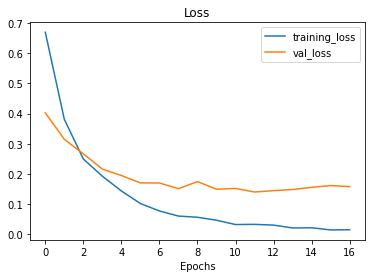

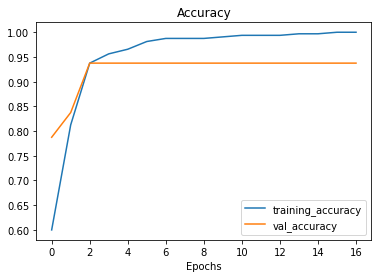

In [ ]:
plot_loss_curves(history)

In [ ]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

4/4 [==============================] - 5s 911ms/step
The first 5 predictions: ['nonfire', 'fire', 'nonfire', 'fire', 'fire']


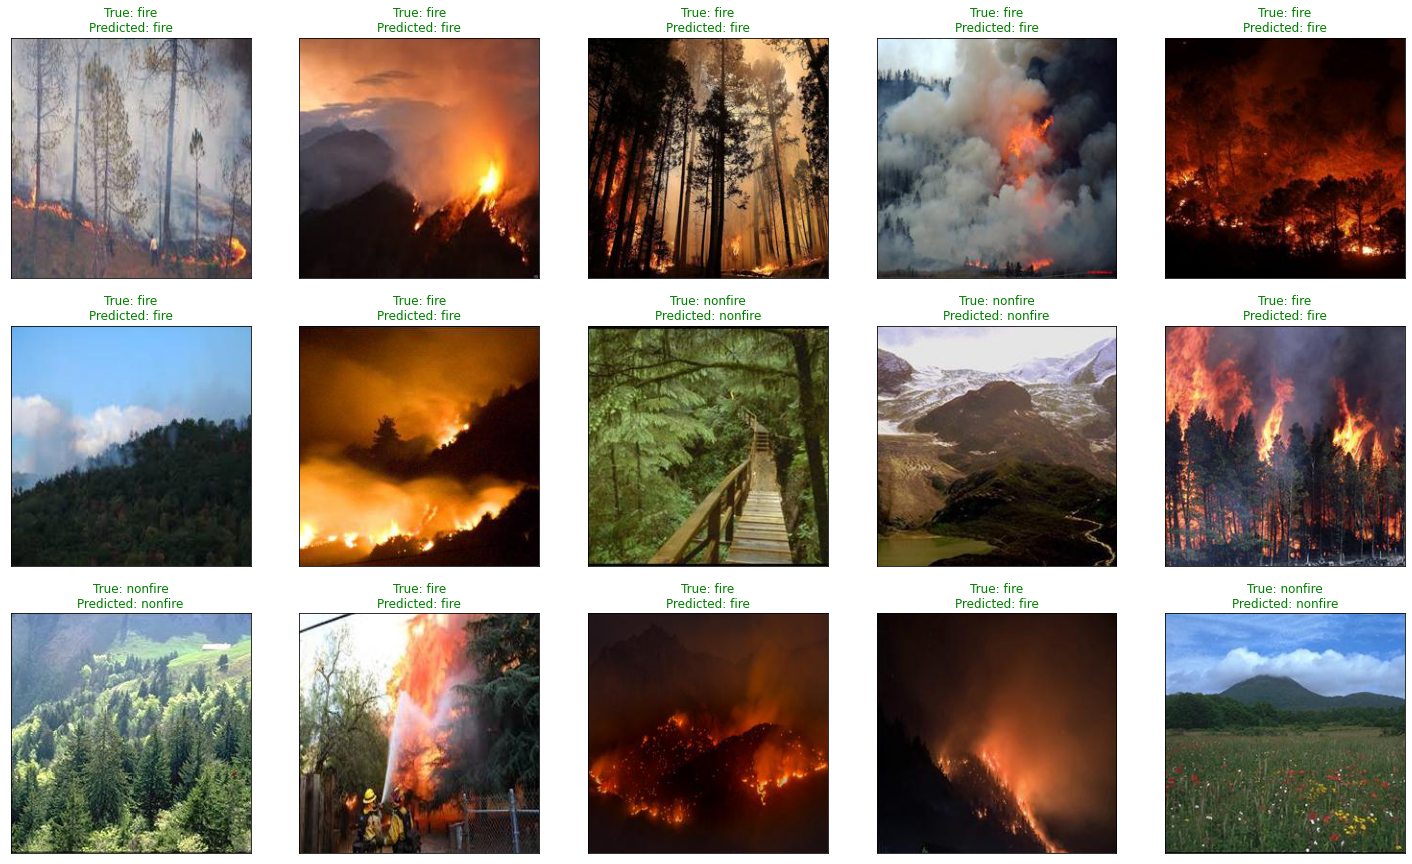

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_predictions(test_df, predictions)

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       0.97      1.00      0.98        64
     nonfire       1.00      0.94      0.97        36

    accuracy                           0.98       100
   macro avg       0.98      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

,precision,recall,f1-score,support
fire,0.969697,1.000000,0.984615,64.00
nonfire,1.000000,0.944444,0.971429,36.00
accuracy,0.980000,0.980000,0.980000,0.98
macro avg,0.984848,0.972222,0.978022,100.00
weighted avg,0.980606,0.980000,0.979868,100.00


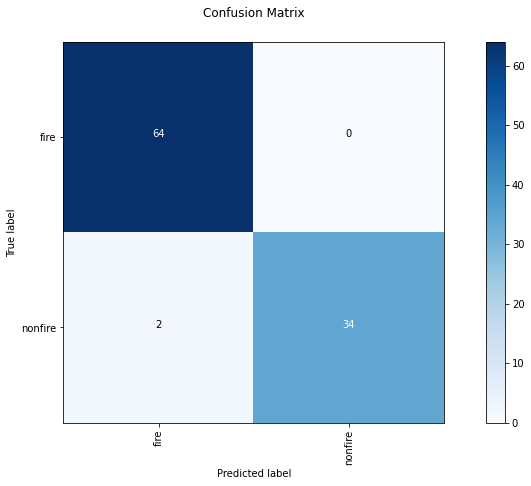

In [ ]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [ ]:
model.save('model_70-30.h5')

##### Train 30-70

In [ ]:
train_df, test_df = train_test_split(
    df_30_70, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [ ]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20221221-162626
Epoch 1/100
10/10 [==============================] - 114s 11s/step - loss: 0.6516 - accuracy: 0.6219 - val_loss: 0.5511 - val_accuracy: 0.6875
Epoch 2/100
10/10 [==============================] - 19s 2s/step - loss: 0.3916 - accuracy: 0.8375 - val_loss: 0.3788 - val_accuracy: 0.8125
Epoch 3/100
10/10 [==============================] - 17s 2s/step - loss: 0.2303 - accuracy: 0.9281 - val_loss: 0.2069 - val_accuracy: 0.9500
Epoch 4/100
10/10 [==============================] - 19s 2s/step - loss: 0.1489 - accuracy: 0.9812 - val_loss: 0.1433 - val_accuracy: 0.9625
Epoch 5/100
10/10 [==============================] - 18s 2s/step - loss: 0.1043 - accuracy: 0.9812 - val_loss: 0.1229 - val_accuracy: 0.9625
Epoch 6/100
10/10 [==============================] - 18s 2s/step - loss: 0.0892 - accuracy: 0.9812 - val_loss: 0.0917 - val_accuracy: 0.9625
Epoch 7/100
10/10 [==============================] - 19s 2s/step - lo

In [ ]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.04074
Test Accuracy:  97.00


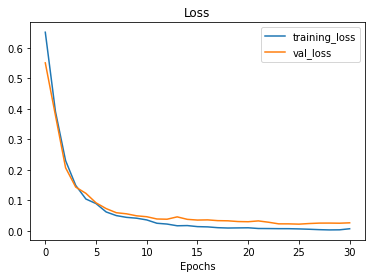

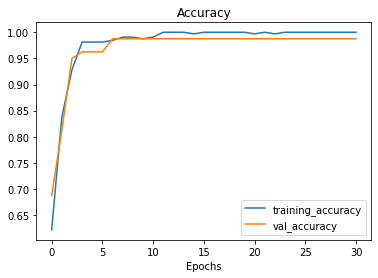

In [ ]:
plot_loss_curves(history)

In [ ]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

4/4 [==============================] - 5s 920ms/step
The first 5 predictions: ['nonfire', 'fire', 'nonfire', 'nonfire', 'fire']


In [ ]:
plot_predictions(test_df, predictions)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       1.00      0.91      0.95        33
     nonfire       0.96      1.00      0.98        67

    accuracy                           0.97       100
   macro avg       0.98      0.95      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

,precision,recall,f1-score,support
fire,1.000000,0.909091,0.952381,33.00
nonfire,0.957143,1.000000,0.978102,67.00
accuracy,0.970000,0.970000,0.970000,0.97
macro avg,0.978571,0.954545,0.965242,100.00
weighted avg,0.971286,0.970000,0.969614,100.00


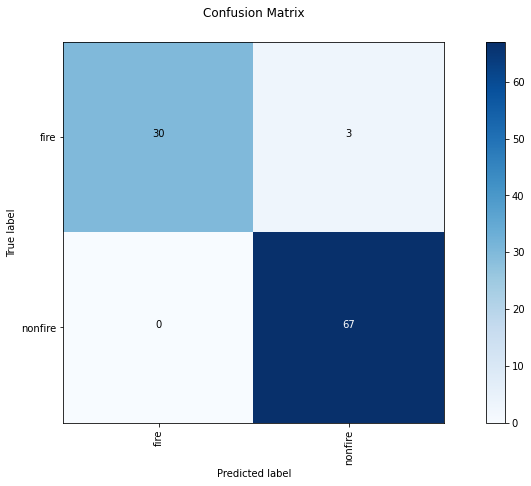

In [ ]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [ ]:
model.save('model_30-70.h5')